# Perform Facial Recognition with Deep Learning in Keras Using CNN 

### Problem Statement:
Facial recognition is a biometric alternative that measures unique characteristics of a human
face. Applications available today include flight check in, tagging friends and family members in
photos, and “tailored” advertising. You are a computer vision engineer who needs to develop a
face recognition programme with deep convolutional neural networks.
### Objective:
Use a deep convolutional neural network to perform facial recognition using Keras.
### Dataset Details:
ORL face database composed of 400 images of size 112 x 92. There are 40 people, 10 images
per person. The images were taken at different times, lighting and facial expressions. The faces
are in an upright position in frontal view, with a slight left-right rotation.

We'll start with the reading in the data, and separating the Train and Test datasets.

In [1]:
# Import libraries necessary for this project

# Data science libraries
import numpy as np
import pandas as pd

#Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Keras API libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, LeakyReLU,BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K 
from keras.models import Model, load_model

#Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#loading dataset
#data = np.load('/content/drive/MyDrive/ORL_faces.npz') 
data = np.load('ORL_faces.npz') 

In [4]:
# Loading train and test dataset (data is already split into)
X_train = data['trainX']
y_train = data['trainY']
X_test = data['testX']
y_test = data['testY']

# print the shape of dataset
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(240, 10304)
(240,)
(160, 10304)
(160,)


In [5]:
# Normalizing each image as each image is between 0-255 pixels
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

print('Training dataset shape: ',X_train.shape)
print('Testing dataset shape: ',X_test.shape)

Training dataset shape:  (240, 10304)
Testing dataset shape:  (160, 10304)


In [6]:
# Shape of image definition
rows = 112
columns = 92
image_shape = (rows,columns,1)

In [7]:
# Reshape the images
X_train = X_train.reshape(X_train.shape[0],*image_shape)
X_test = X_test.reshape(X_test.shape[0],*image_shape)

In [8]:
print('Training dataset modified shape: ',X_train.shape)
print('Testing dataset modified shape: ',X_test.shape)

Training dataset modified shape:  (240, 112, 92, 1)
Testing dataset modified shape:  (160, 112, 92, 1)


In [9]:
y_train.shape , y_test.shape

((240,), (160,))

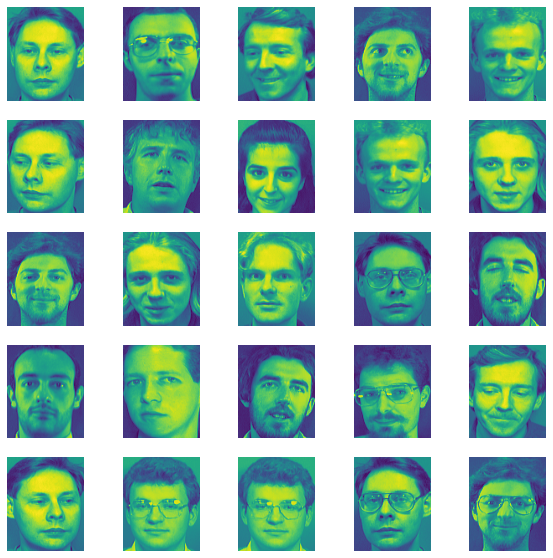

In [10]:
#visualize random images using 5 x 5 grid images in gray scale
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow((X_train[np.random.randint(X_train.shape[0])])) # for gray scale
plt.show()

In [14]:
#Define image parameters
img_size = [112,92,1]

In [15]:
# Creating function to Extract and Augment the images from Dataset
def batch_generator(df_images,df_labels, batchsize=32, train_mode=True):   
    
    # Data Augmentation to reduce overfitting
    img_generator= ImageDataGenerator(featurewise_center=True,
                                            rotation_range=20,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            zoom_range = 0.2,
                                            horizontal_flip=True)
    
    
    while True:        
                
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,df_images.shape[0], batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,*img_size))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, len(np.unique(df_labels))))
        
        for i in range(batchsize):
          #get the image
          img = df_images[batch_nums[i]]
            
          #Applying Data augmentation for only training dataset
          if(train_mode):
              #Apply transform
              img =  img_generator.random_transform(img)
          
          #Get the class
          img_class = df_labels[batch_nums[i]]
          #Convert class to one hot encoding
          img_class = to_categorical(img_class, num_classes=len(np.unique(df_labels)))
          
          #Update batch images and class arrays
          batch_images[i] = img
          batch_labels[i] = img_class    
                                                        
        yield batch_images, batch_labels

In [16]:
#Create train and test generator
batchsize = 20
train_generator = batch_generator(X_train,y_train, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(X_test,y_test, batchsize=batchsize, train_mode=False)

In [26]:
#Create Cnn Model
activation = 'relu'
K.clear_session()
model = Sequential()
model.add(Conv2D(32, 3, activation = activation, padding = 'same',   #32 filters with kernel size of 3 with input shape
                 input_shape = (112, 92, 1)))
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same',   #32 filters with kernel size of 3 with input shape
                 kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = activation, padding = 'same',    #64 filters with kernel size of 3 with input shape
                 kernel_initializer = 'he_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same',     #64 filters with kernel size of 3 with input shape
                 kernel_initializer = 'he_uniform'))
model.add(Dropout(0.3))

model.add(Conv2D(64, 3, activation = activation, padding = 'same',     #64 filters with kernel size of 3 with input shape
                 kernel_initializer = 'he_uniform'))
model.add(Dropout(0.3))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

#Flatten the image
model.add(Flatten())
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(20, activation = 'softmax'))

#compile model with loss, optimizer chosen and accuracy as metrics
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 92, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 92, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 92, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 92, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 46, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 56, 46, 64)        0

In [27]:
#apply checkpoints to save improved weights for specific epoch
file_path = '/content/drive/MyDrive/Colab Notebooks/Facial_Recognition/Checkpoints/weights-improvement-{epoch:02d}--{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', 
                                       verbose=1, save_best_only=True, mode='max')

In [28]:
#Fit the model
Final_model = model.fit_generator(train_generator, 
                          epochs=65,
                          steps_per_epoch= X_train.shape[0]//batchsize,
                          validation_data=test_generator,
                          validation_steps = X_test.shape[0]//batchsize,
                          callbacks = checkpoint)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/65
12/12 [==============================] - 2s 92ms/step - loss: 23.2272 - accuracy: 0.0985 - val_loss: 18.7264 - val_accuracy: 0.0437

Epoch 00001: val_accuracy improved from -inf to 0.04375, saving model to /content/drive/MyDrive/Colab Notebooks/Facial_Recognition/Checkpoints/weights-improvement-01--0.04.hdf5
Epoch 2/65
12/12 [==============================] - 0s 35ms/step - loss: 5.7764 - accuracy: 0.2005 - val_loss: 33.1768 - val_accuracy: 0.0562

Epoch 00002: val_accuracy improved from 0.04375 to 0.05625, saving model to /content/drive/MyDrive/Colab Notebooks/Facial_Recognition/Checkpoints/weights-improvement-02--0.06.hdf5
Epoch 3/65
12/12 [==============================] - 0s 36ms/step - loss: 3.3691 - accuracy: 0.1864 - val_loss: 42.2111 - val_accuracy: 0.0688

Epoch 00003: val_accuracy improved from 0.05625 to 0.06875, saving model to /content/drive/MyDrive/Colab Notebooks/Facial_Recognition/Checkpoints/weights-improvement-03--0.07.hdf5
Epoch 4/65
12/12 [===============

In [29]:
print(Final_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


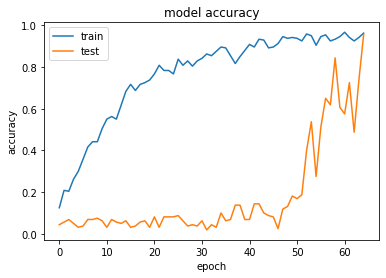

In [30]:
# summarize history for accuracy
plt.plot(Final_model.history['accuracy'])
plt.plot(Final_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

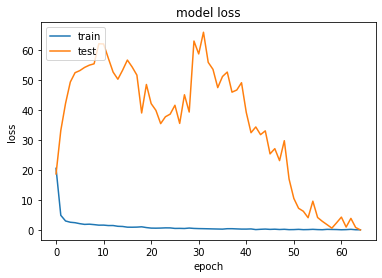

In [31]:
# summarize history for loss
plt.plot(Final_model.history['loss'])
plt.plot(Final_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
#Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/Facial_Recognition/Facial_Recognition_model1.h5')

In [33]:
# load the model
face_rec_model = load_model('/content/drive/MyDrive/Colab Notebooks/Facial_Recognition/Facial_Recognition_model1.h5')
# summarize model.
face_rec_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 92, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 92, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 92, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 92, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 46, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 56, 46, 64)        0

In [34]:
# prediction for unseen data
pred_Y = face_rec_model.predict(X_test, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)

5/5 [==============================] - 1s 11ms/step


In [36]:
#get the accuracy_score for prediction
print('Accuracy for test dataset:',accuracy_score(y_test, pred_Y_cat))

Accuracy for test dataset: 0.975


In [37]:
#Get the classification report for prediction
print(classification_report(y_test, pred_Y_cat))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       0.89      1.00      0.94         8
           5       1.00      1.00      1.00         8
           6       0.89      1.00      0.94         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       0.89      1.00      0.94         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       0.89      1.00      0.94         8
          17       1.00    

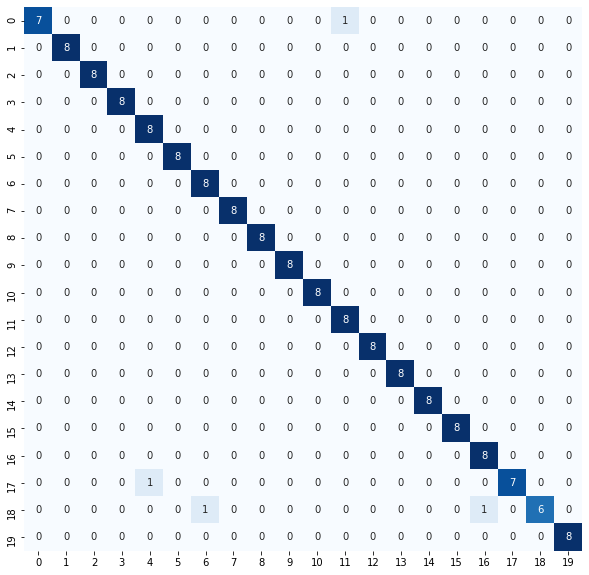

In [38]:
#Lets plot the confusion_matrix using heatmap in seaborn
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_test.shape[0]//20)

## Conclusion

* In this project we analyzed ORL faces images. We used CNN method to build the model and train it.
* The model training is done using X_train and y_train with validation data as X_test and y_test. however for evaluating model, we use X_test and y_test which gives us <b> loss ~0.0826  </b>  with <b> an accuracy of 95.63% </b>